<a href="https://colab.research.google.com/github/Daku-on/qiita_article/blob/main/%E3%83%9D%E3%82%B1%E3%83%9D%E3%82%B1%E5%8B%9D%E8%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.ticker import MaxNLocator
from collections import Counter

In [2]:
# Constants
NUM_PLAYERS = 50000
WIN_CONDITION = 5
BETRAYAL_RATE = 0.1
PARTICIPATION_RATE = 0.5

In [3]:
def simulate_game(
    num_players: int = NUM_PLAYERS,
    win_condition: int = WIN_CONDITION,
    betrayal_rate: float = BETRAYAL_RATE,
    participation_rate: float = PARTICIPATION_RATE
):
    # Initialize players and stats
    players = np.zeros((num_players, 2), dtype=int)  # [consecutive_wins, cleared_flag]
    player_battles = np.zeros(num_players, dtype=int)  # Count battles per player
    cleared_count = []
    history = []
    rounds = 0

    # Function to simulate a single round
    def simulate_round(players: np.ndarray, player_battles: np.ndarray) -> None:
        indices = np.arange(len(players))  # Array of player indices
        np.random.shuffle(indices)  # Shuffle players for random pairing

        for i in range(0, len(indices) - 1, 2):  # Pair players
            player_i, player_j = indices[i], indices[i + 1]

            # Skip if both players are already cleared
            if players[player_i, 1] and players[player_j, 1]:  # Cleared flag
                continue

            # Handle cleared players with participation chance
            if players[player_i, 1]:  # Cleared
                if random.random() < participation_rate:
                    players[player_j, 0] += 1  # Increment consecutive wins
                    if players[player_j, 0] >= win_condition:
                        players[player_j, 1] = 1  # Mark as cleared
                continue
            if players[player_j, 1]:  # Cleared
                if random.random() < participation_rate:
                    players[player_i, 0] += 1  # Increment consecutive wins
                    if players[player_i, 0] >= win_condition:
                        players[player_i, 1] = 1  # Mark as cleared
                continue

            # Battle logic
            if (
                players[player_i, 0] == players[player_j, 0]  # Same wins
                or (players[player_i, 0] == 1 and players[player_j, 0] == 0)  # 1 win vs 0 wins
                or (players[player_i, 0] == 0 and players[player_j, 0] == 1)  # 0 wins vs 1 win
                or random.random() < betrayal_rate  # Betrayal
            ):
                # Fair battle or betrayal
                winner = random.choice([player_i, player_j])
                loser = player_i if winner == player_j else player_j
                players[winner, 0] += 1  # Increment consecutive wins
                players[loser, 0] = 0  # Reset consecutive wins
            else:
                # Unequal wins: stronger wins
                if players[player_i, 0] > players[player_j, 0]:
                    players[player_i, 0] += 1
                    players[player_j, 0] = 0
                else:
                    players[player_j, 0] += 1
                    players[player_i, 0] = 0

            # Update cleared status
            if players[player_i, 0] >= win_condition:
                players[player_i, 1] = 1
            if players[player_j, 0] >= win_condition:
                players[player_j, 1] = 1

            # Count the battle
            player_battles[player_i] += 1
            player_battles[player_j] += 1

    # Simulation loop
    while np.sum(players[:, 1]) < num_players:  # While not all players are cleared
        simulate_round(players, player_battles)
        cleared_count.append(np.sum(players[:, 1]))  # Track cleared players
        history.append(players[:, 0].copy())  # Track consecutive wins
        rounds += 1

    return {
        "rounds": rounds,
        "cleared_count": cleared_count,
        "player_battles": player_battles,
        "history": history,
    }


# Visualization functions
def visualize_cleared_count(cleared_count):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cleared_count) + 1), cleared_count, marker='o', label="Cleared Players")
    plt.xlabel("Rounds")
    plt.ylabel("Cleared Players")
    plt.title("Progression of Cleared Players")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Force x-axis to show integers
    plt.legend()
    plt.grid()
    plt.show()


def visualize_battle_distribution(player_battles):
    plt.figure(figsize=(8, 5))
    plt.hist(player_battles, bins=range(0, max(player_battles) + 2), align='left', rwidth=0.8)
    plt.xlabel("Number of Battles")
    plt.ylabel("Number of Players")
    plt.title("Distribution of Battles per Player")
    plt.xticks(range(0, max(player_battles) + 2))  # Ensure integer ticks
    plt.grid(axis='y')
    plt.show()

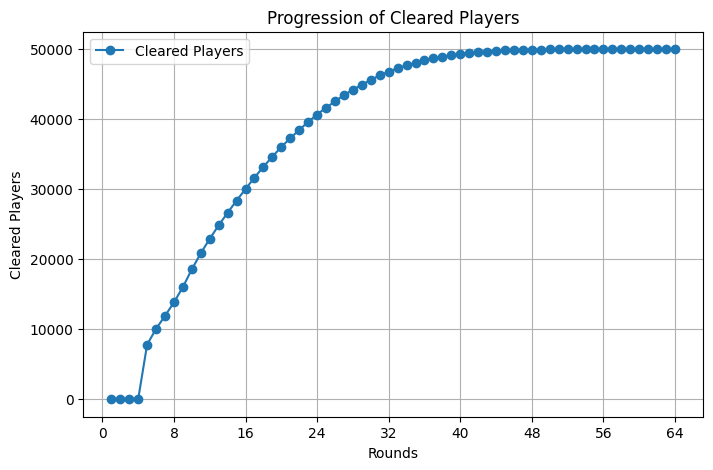

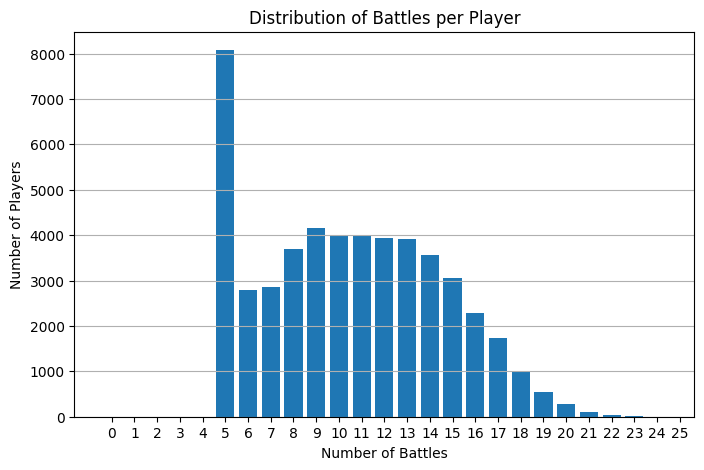

Total rounds: 64
Average battles per player: 10.49


In [4]:
# Run the simulation
results = simulate_game()

# Visualize the results
visualize_cleared_count(results["cleared_count"])
visualize_battle_distribution(results["player_battles"])

# Print stats
print(f"Total rounds: {results['rounds']}")
average_battles_per_player = np.sum(results["player_battles"]) / NUM_PLAYERS
print(f"Average battles per player: {average_battles_per_player:.2f}")